In [1]:
import os 
import numpy as np
import torch 
import matplotlib.pyplot as plt

In [2]:
reverb_log_dir = '../Logs/8cm_array_2mic/reverb/simu_rirs'
noisy_log_dir = '../Logs/8cm_array_2mic/noisy'
noisy_reverb_ps_log_dir = '../Logs/8cm_array_2mic/noisy_reverb/point_source'
noisy_reverb_diffuse_log_dir = '../Logs/8cm_array_2mic/noisy_reverb/diffuse/simu_rirs_doa_mask'

In [3]:
Loss = ["MISO_RI", "MISO_RI_MAG"]
num_mics_list = [2]
doa_measures = ["est_frm_Acc_epoch", "utt_Acc_epoch", 'mae_only_correct', 'mae_only_incorrect', 'mae_overall']
se_measures = ["STOI", "PESQ_NB", "SNR"]

In [4]:
search_doa_pattern_list = []
for loss in Loss:
    for measure in doa_measures:
        doa_info_pattern = f'{loss}_{measure}' #inside file pattern
        search_doa_pattern_list.append(doa_info_pattern)

search_doa_pattern_list.append("mix_frm_Acc_epoch") 

In [5]:
def get_test_config_details(line):
    snr,t60,app_str = None, None,""
    
    if "dataset_condition:" in line:
        line_split_info = line.split(',')
        if line_split_info[-1]=='':
            line_split_info.pop()
        dataset_condition = line_split_info[-1].split()[-1]
        if dataset_condition=="noisy":
            snr = line_split_info[-3].split()[-1]
            app_str = f'snr_{snr}'
        elif dataset_condition=="noisy_reverb":
            
            snr = line_split_info[-3].split()[-1]
            t60 = line_split_info[-4].split()[-1]
            app_str = f'snr_{snr}_t60_{t60}'
            
        elif dataset_condition=="reverb":
            t60 = line_split_info[-4].split()[-1]
            app_str = f't60_{t60}'

            
    return snr, t60, app_str

In [6]:
#search_pattern_file
def search_pattern_file(file_path, search_pattern_list):
    exp_dict = {}
    app_str = ""
    with open(file_path, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            if app_str=="":
                snr, t60, app_str = get_test_config_details(line)
                
            for search_pattern in search_pattern_list: #search_doa_pattern_list:
                if search_pattern in line:
                    line_split_info = line.split()
                    #print(line_split_info, len(line_split_info))
                    if len(line_split_info)==5:
                        key_str = f'{search_pattern}_{app_str}'
                        exp_dict[key_str] = float(line_split_info[3])
                        #print(key_str, line.split()[3])
                
    return exp_dict
        


In [7]:
def get_all_exp_dict(log_dir: str, search_pattern: list):
    log_dir_files = os.listdir(log_dir)
    log_dir_files = [x for x in log_dir_files if os.path.isfile(os.path.join(log_dir, x))]
    _exp_dict={}
    for _file in log_dir_files:
        file_path = os.path.join(log_dir, _file)
        exp_dict = search_pattern_file(file_path, search_pattern)
        _exp_dict.update(exp_dict)
    
    return _exp_dict

In [8]:
reverb_exp_dict = get_all_exp_dict(reverb_log_dir, search_doa_pattern_list)
noisy_exp_dict = get_all_exp_dict(noisy_log_dir, search_doa_pattern_list)
noisy_reverb_ps_exp_dict = get_all_exp_dict(noisy_reverb_ps_log_dir, search_doa_pattern_list)
noisy_reverb_diffuse_exp_dict = get_all_exp_dict(noisy_reverb_diffuse_log_dir, search_doa_pattern_list)

In [9]:
#plotting frm Acc
from itertools import product

noisy_snr_list = [-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]

noisy_reverb_snr_list = [-5.0, 0.0, 5.0, 10.0, 20.0 ]
noisy_reverb_t60_list = [0.2, 0.4, 0.6, 0.8, 1.0]
noisy_reverb_list = list(product(noisy_reverb_snr_list, noisy_reverb_t60_list))

reverb_t60_list = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [10]:
def build_app_str(dataset_condition, val):
    if dataset_condition=="noisy":
        app_str = f'snr_{val}'
    elif dataset_condition=="noisy_reverb":
        app_str = f'snr_{val[0]}_t60_{val[1]}'   
    elif dataset_condition=="reverb":
        app_str = f't60_{val}'
    return app_str

In [11]:
def _plot(measure, exp_dict, dataset_condition, tst_conditions, loss_list, dataset_simulation=""):
    plt.figure()
    for loss in loss_list:
        val_list = []
        for tst_val in tst_conditions:
            app_str = build_app_str(dataset_condition, tst_val)
            key_str = f'{loss}_{measure}_{app_str}'

            val_list.append(exp_dict[key_str])
        #print(loss, val_list)
        if dataset_condition != "noisy_reverb":
            plt.plot(tst_conditions, val_list) 
        else:
            plt.plot(val_list) 
    plt.legend(loss_list)
    plt.title(f'{dataset_condition}_{dataset_simulation}')
        
        


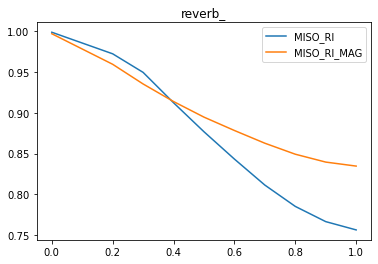

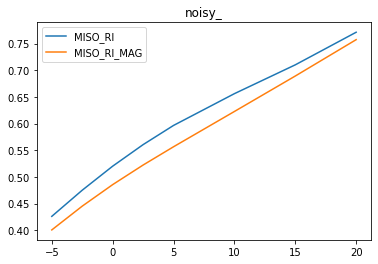

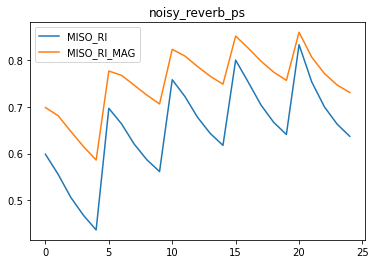

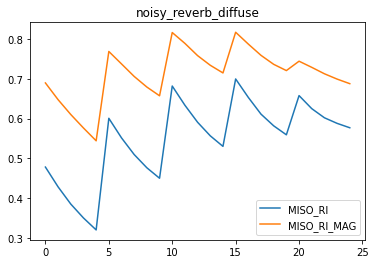

In [12]:
_plot("est_frm_Acc_epoch", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_plot("est_frm_Acc_epoch", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_plot("est_frm_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_plot("est_frm_Acc_epoch", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")

In [13]:
def _print(measure, exp_dict, dataset_condition, tst_conditions, loss_list, dataset_simulation=""):
    print(tst_conditions)
    for loss in loss_list:
        val_list = []
        for tst_val in tst_conditions:
            app_str = build_app_str(dataset_condition, tst_val)
            key_str = f'{loss}_{measure}_{app_str}'

            val_list.append(exp_dict[key_str])
        print(loss, val_list)

        
        


In [16]:
_print("est_frm_Acc_epoch", reverb_exp_dict, "reverb", reverb_t60_list, Loss)
_print("est_frm_Acc_epoch", noisy_exp_dict, "noisy", noisy_snr_list, Loss)
_print("est_frm_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "ps")
_print("frm_Acc_epoch", noisy_reverb_ps_exp_dict, "noisy_reverb", noisy_reverb_list, ["mix"], "ps")
_print("est_frm_Acc_epoch", noisy_reverb_diffuse_exp_dict, "noisy_reverb", noisy_reverb_list, Loss, "diffuse")


[0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
MISO_RI [0.9988895058631897, 0.9724327921867371, 0.9496573805809021, 0.9124163389205933, 0.8768355250358582, 0.8433189392089844, 0.8114238381385803, 0.7852669358253479, 0.766593337059021, 0.7564226984977722]
MISO_RI_MAG [0.9970663189888, 0.9595805406570435, 0.9354431629180908, 0.9139018654823303, 0.8947674632072449, 0.8783785700798035, 0.8627665042877197, 0.8492816686630249, 0.8396276831626892, 0.8347100019454956]
[-5.0, -2.5, 0.0, 2.5, 5.0, 10.0, 15.0, 20.0]
MISO_RI [0.42608627676963806, 0.47511667013168335, 0.5201789736747742, 0.560584306716919, 0.5965930223464966, 0.656189501285553, 0.7102378606796265, 0.7713657021522522]
MISO_RI_MAG [0.40063631534576416, 0.44522708654403687, 0.4855840504169464, 0.5223197937011719, 0.556594967842102, 0.622769832611084, 0.6892622709274292, 0.7574594616889954]
[(-5.0, 0.2), (-5.0, 0.4), (-5.0, 0.6), (-5.0, 0.8), (-5.0, 1.0), (0.0, 0.2), (0.0, 0.4), (0.0, 0.6), (0.0, 0.8), (0.0, 1.0), (5.0, 0.2), (5.0,

In [15]:
reverb_exp_dict

{'mix_frm_Acc_epoch_t60_1.0': 0.1877395361661911,
 'mix_frm_Acc_epoch_t60_0.8': 0.21359437704086304,
 'mix_frm_Acc_epoch_t60_0.7': 0.23226924240589142,
 'mix_frm_Acc_epoch_t60_0.9': 0.19937919080257416,
 'mix_frm_Acc_epoch_t60_0.0': 1.0,
 'mix_frm_Acc_epoch_t60_0.6': 0.25647851824760437,
 'mix_frm_Acc_epoch_t60_0.5': 0.290723592042923,
 'mix_frm_Acc_epoch_t60_0.2': 0.6307407021522522,
 'mix_frm_Acc_epoch_t60_0.3': 0.4351670444011688,
 'mix_frm_Acc_epoch_t60_0.4': 0.34386155009269714,
 'MISO_RI_MAG_est_frm_Acc_epoch_t60_0.8': 0.8492816686630249,
 'MISO_RI_est_frm_Acc_epoch_t60_0.8': 0.7852669358253479,
 'MISO_RI_MAG_est_frm_Acc_epoch_t60_0.5': 0.8947674632072449,
 'MISO_RI_est_frm_Acc_epoch_t60_0.5': 0.8768355250358582,
 'MISO_RI_MAG_est_frm_Acc_epoch_t60_0.2': 0.9595805406570435,
 'MISO_RI_est_frm_Acc_epoch_t60_0.2': 0.9724327921867371,
 'MISO_RI_MAG_est_frm_Acc_epoch_t60_0.0': 0.9970663189888,
 'MISO_RI_est_frm_Acc_epoch_t60_0.0': 0.9988895058631897,
 'MISO_RI_MAG_est_frm_Acc_epoch_t6